# EMATM0048 - Tutorial 10A
# Exploratory Data Analysis using Python - A Case Study

*Analyzing responses from the Stack Overflow Annual Developer Survey 2020*

This tutorial is modified from https://jovian.ai/aakashns/python-eda-stackoverflow-survey

The following topics are covered in this tutorial:

- Selecting and downloading a dataset
- Data preparation and cleaning
- Exploratory analysis and visualization
- Asking and answering interesting questions
- Summarising inferences and drawing conclusions

## Introduction

In this tutorial, we'll analyse the StackOverflow developer survey dataset. The dataset contains responses to an annual survey conducted by StackOverflow. You can find the raw data & official analysis here: https://insights.stackoverflow.com/survey.

Let's read the data first

In [72]:
import os #os库是Python标准库中的一个子库，它提供了一种方便的使用操作系统函数的方法。
os.listdir('stackoverflow-developer-survey-2020') #列出文件夹下所有的目录与文件

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'stackoverflow-developer-survey-2020'

You can through the downloaded files using the "File" > "Open" menu option in Jupyter. It seems like the dataset contains three files:

- `README.txt` - Information about the dataset
- `survey_results_schema.csv` - The list of questions, and shortcodes for each question
- `survey_results_public.csv` - The full list of responses to the questions 

Let's load the CSV files using the Pandas library. We'll use the name `survey_raw_df` for the data frame to indicate this is unprocessed data that we might clean, filter, and modify to prepare a data frame ready for analysis.

In [ ]:
import pandas as pd

In [ ]:
survey_raw_df = pd.read_csv('E:\Programming\Dataset_prac\stackoverflow-developer-survey-2020\survey_results_public.csv')

In [ ]:
survey_raw_df

The dataset contains over 64,000 responses to 60 questions (although many questions are optional). The responses have been anonymized to remove personally identifiable information, and each respondent has been assigned a randomized respondent ID.

Let's view the list of columns in the data frame. 

In [ ]:
survey_raw_df.columns

It appears that shortcodes for questions have been used as column names. 

We can refer to the schema file to see the full text of each question. The schema file contains only two columns: `Column` and `QuestionText`. We can load it as Pandas Series with `Column` as the index and the  `QuestionText` as the value.

In [73]:
schema_fname = 'E:\Programming\Dataset_prac\stackoverflow-developer-survey-2020\survey_results_schema.csv'
schema_raw = pd.read_csv(schema_fname, index_col='Column')

In [74]:
schema_raw

,QuestionText
Column,
Respondent,Randomized respondent ID number (not in order ...
MainBranch,Which of the following options best describes ...
Hobbyist,Do you code as a hobby?
Age,What is your age (in years)? If you prefer not...
Age1stCode,At what age did you write your first line of c...
...,...
WebframeWorkedWith,Which web frameworks have you done extensive d...
WelcomeChange,"Compared to last year, how welcome do you feel..."
WorkWeekHrs,"On average, how many hours per week do you wor..."


We can now use `schema_raw` to retrieve the full question text for any column in `survey_raw_df`.

In [75]:
schema_raw['YearsCodePro']

KeyError: 'YearsCodePro'

We've now loaded the dataset. We're ready to move on to the next step of preprocessing & cleaning the data for our analysis.

## Data Preparation & Cleaning

While the survey responses contain a wealth of information, we'll limit our analysis to the following areas:

- Demographics of the survey respondents and the global programming community
- Distribution of programming skills, experience, and preferences
- Employment-related information, preferences, and opinions

Let's select a subset of columns with the relevant data for our analysis.

In [ ]:
selected_columns = [
    # Demographics
    'Country',
    'Age',
    'Gender',
    'EdLevel',
    'UndergradMajor',
    # Programming experience
    'Hobbyist',
    'Age1stCode',
    'YearsCode',
    'YearsCodePro',
    'LanguageWorkedWith',
    'LanguageDesireNextYear',
    'NEWLearn',
    'NEWStuck',
    # Employment
    'Employment',
    'DevType',
    'WorkWeekHrs',
    'JobSat',
    'JobFactors',
    'NEWOvertime',
    'NEWEdImpt'
]

In [ ]:
len(selected_columns)

Let's extract a copy of the data from these columns into a new data frame `survey_df`. We can continue to modify further without affecting the original data frame.

In [ ]:
survey_df = survey_raw_df[selected_columns].copy()
# type(schema_raw)

In [ ]:
schema = schema_raw.loc[selected_columns] 

Let's view some basic information about the data frame.

In [ ]:
survey_df.shape

In [ ]:
survey_df.info()

Most columns have the data type `object`, either because they contain values of different types or contain empty values (`NaN`). It appears that every column contains some empty values since the Non-Null count for every column is lower than the total number of rows (64461). We'll need to deal with empty values and manually adjust the data type for each column on a case-by-case basis. 

Only two of the columns were detected as numeric columns (`Age` and `WorkWeekHrs`), even though a few other columns have mostly numeric values. To make our analysis easier, let's convert some other columns into numeric data types while ignoring any non-numeric value. The non-numeric are converted to `NaN`.


In [ ]:
survey_df['Age1stCode'] = pd.to_numeric(survey_df.Age1stCode, errors='coerce')
survey_df['YearsCode'] = pd.to_numeric(survey_df.YearsCode, errors='coerce')
survey_df['YearsCodePro'] = pd.to_numeric(survey_df.YearsCodePro, errors='coerce')

Let's now view some basic statistics about numeric columns.

In [ ]:
survey_df.describe()

There seems to be a problem with the age column, as the minimum value is 1 and the maximum is 279. This is a common issue with surveys: responses may contain invalid values due to accidental or intentional errors while responding. 

A simple fix would be to ignore the rows where the age is higher than 100 years or lower than 10 years as invalid survey responses. We can do this using the `.drop` method,

In [ ]:
survey_df.drop(survey_df[survey_df.Age < 10].index, inplace=True)
survey_df.drop(survey_df[survey_df.Age > 100].index, inplace=True)

The same holds for `WorkWeekHrs`. Let's ignore entries where the value for the column is higher than 140 hours. (~20 hours per day).

In [ ]:
survey_df.drop(survey_df[survey_df.WorkWeekHrs > 140].index, inplace=True)
# survey_df.describe()

The gender column also allows for picking multiple options. We'll remove values containing more than one option to simplify our analysis.

In [ ]:
survey_df['Gender'].value_counts()

In [ ]:
import numpy as np

In [ ]:
survey_df.where(~(survey_df.Gender.str.contains(';', na=False)), other=np.nan, inplace=True)
# where(condition, other=nan, inplace=False, axis=None, level=None, errors='raise', try_cast=False)
# 表示如果condition为真，则返回原来的值，否则返回other的值
# ~表示取反

In [ ]:
survey_df['Gender'].value_counts()

We've now cleaned up and prepared the dataset for analysis. Let's take a look at a sample of rows from the data frame.

In [76]:
# survey_df.sample(10) #随机抽取10行
survey_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64306 entries, 0 to 64460
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 63606 non-null  object 
 1   Age                     45068 non-null  float64
 2   Gender                  50115 non-null  object 
 3   EdLevel                 56981 non-null  object 
 4   UndergradMajor          50619 non-null  object 
 5   Hobbyist                63950 non-null  object 
 6   Age1stCode              57027 non-null  float64
 7   YearsCode               56339 non-null  float64
 8   YearsCodePro            43794 non-null  float64
 9   LanguageWorkedWith      56932 non-null  object 
 10  LanguageDesireNextYear  53688 non-null  object 
 11  NEWLearn                55730 non-null  object 
 12  NEWStuck                54537 non-null  object 
 13  Employment              63394 non-null  object 
 14  DevType                 48983 non-null

可以看到仍然存在很多NaN值，需要进一步处理
对于numeric类型列：可以用平均值填充，`.fillna()`方法
其他非数值型列可以选择删除`dropna()`方法


-----

## Exploratory Analysis and Visualization

Before we ask questions about the survey responses, it would help to understand the respondents' demographics, i.e., country, age, gender, education level, employment level, etc. It's essential to explore these variables to understand how representative the survey is of the worldwide programming community. A survey of this scale generally tends to have some [selection bias](https://en.wikipedia.org/wiki/Selection_bias).


Let's begin by importing `matplotlib.pyplot` and `seaborn`.

In [77]:
#pip install seaborn==0.12
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('darkgrid') #设置背景
matplotlib.rcParams['font.size'] = 14 #设置字体大小
matplotlib.rcParams['figure.figsize'] = (9, 5) #设置图像大小
matplotlib.rcParams['figure.facecolor'] = '#00000000' #设置背景颜色

### Country

Let's look at the number of countries from which there are responses in the survey and plot the ten countries with the highest number of responses.

In [78]:
schema.loc['Country']
schema

,QuestionText
Column,
Country,Where do you live?
Age,What is your age (in years)? If you prefer not...
Gender,"Which of the following describe you, if any? P..."
EdLevel,Which of the following best describes the high...
UndergradMajor,What was your primary field of study?
Hobbyist,Do you code as a hobby?
Age1stCode,At what age did you write your first line of c...
YearsCode,"Including any education, how many years have y..."
YearsCodePro,"NOT including education, how many years have y..."


In [79]:
survey_df.Country.nunique() #nunique()方法返回不同值的个数

183

We can identify the countries with the highest number of respondents using the `value_counts` method.

In [80]:
top_countries = survey_df.Country.value_counts().head(15)
top_countries

United States         12371
India                  8364
United Kingdom         3881
Germany                3864
Canada                 2175
France                 1884
Brazil                 1804
Netherlands            1332
Poland                 1259
Australia              1199
Spain                  1157
Italy                  1115
Russian Federation     1085
Sweden                  879
Pakistan                802
Name: Country, dtype: int64

We can visualize this information using a bar chart.

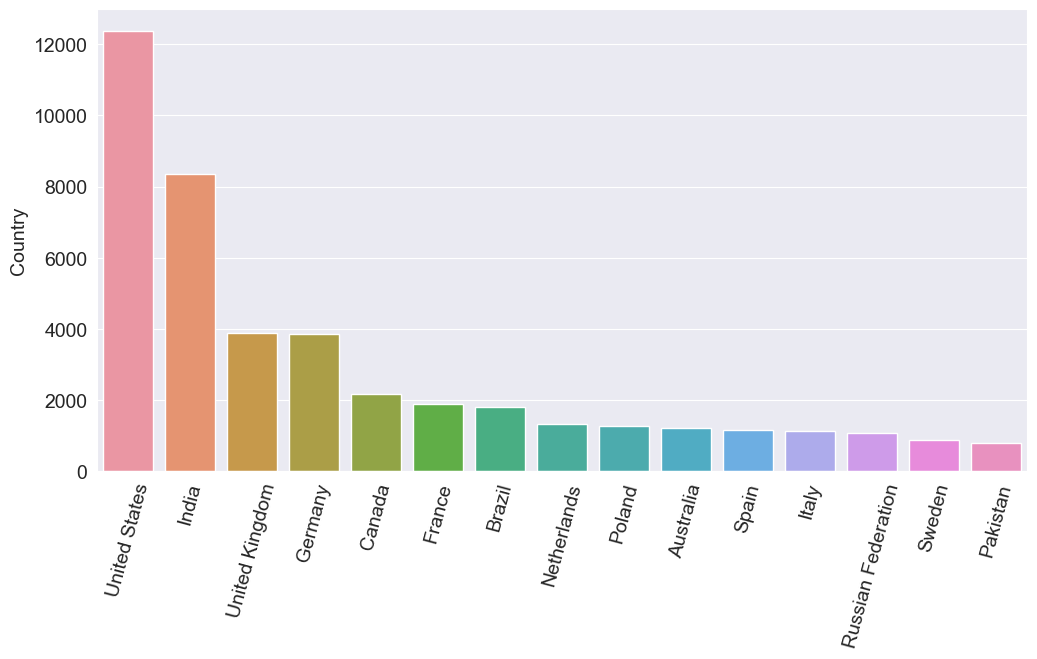

In [81]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=75)
# plt.title(schema.Country)
sns.barplot(x=top_countries.index, y=top_countries);

It appears that a disproportionately high number of respondents are from the US and India, probably because the survey is in English, and these countries have the highest English-speaking populations. We can already see that the survey may not be representative of the global programming community - especially from non-English speaking countries. Programmers from non-English speaking countries are almost certainly underrepresented.

<font color= 'blue'>**Exercise**:</font>

Try finding the percentage of responses from English-speaking vs. non-English speaking countries. 

In [82]:
# 如果要返回百分比，可以用normalize=True
survey_df.Country.str.contains('United Kingdom|United States|India|Canada|Australia|New Zealand|Ireland|South Africa|Singapore').value_counts(normalize=True)


False    0.536129
True     0.463871
Name: Country, dtype: float64

### Age

The distribution of respondents' age is another crucial factor to look at. We can use a histogram to visualize it. 

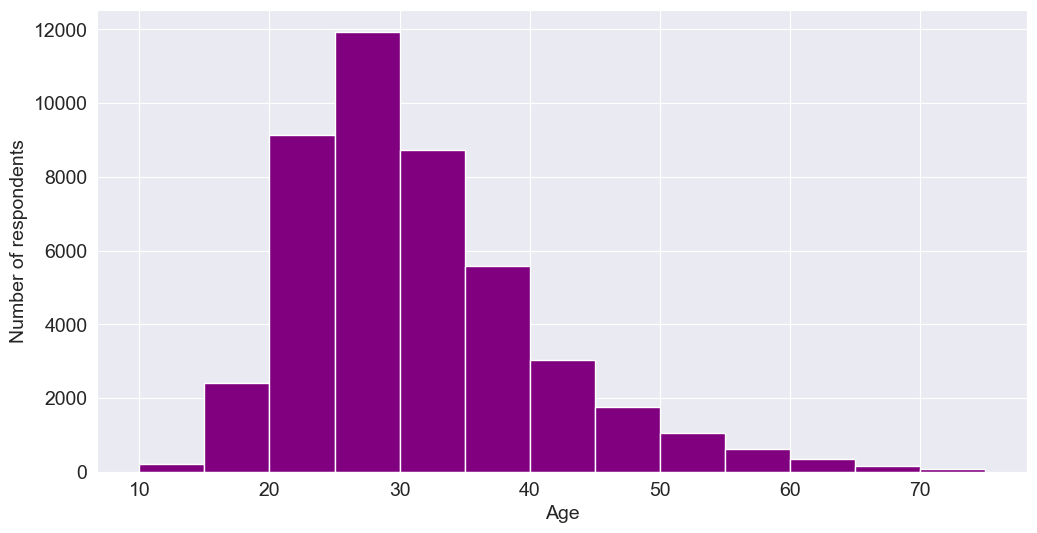

In [85]:
plt.figure(figsize=(12, 6))
plt.xlabel('Age')
plt.ylabel('Number of respondents')

plt.hist(survey_df.Age, bins=np.arange(10,80,5), color='purple');

It appears that a large percentage of respondents are 20-45 years old. It's somewhat representative of the programming community in general. Many young people have taken up computer science as their field of study or profession in the last 20 years.

<font color= 'blue'>**Exercise**:</font>

You may want to filter out responses by age (or age group) if you'd like to analyze and compare the survey results for different age groups. Create a new column called AgeGroup containing values like `Less than 10 years`, `10-18 years`, `18-30 years`, `30-45 years`, `45-60 years` and `Older than 60 years`. Then, repeat the analysis in the rest of this notebook for each age group.


### Gender

Let's look at the distribution of responses for the Gender. It's a well-known fact that women and non-binary genders are underrepresented in the programming community, so we might expect to see a skewed distribution here.

In [86]:
schema.Gender

AttributeError: 'DataFrame' object has no attribute 'Gender'

In [87]:
gender_counts = survey_df.Gender.value_counts()
gender_counts

Man                                                  45895
Woman                                                 3835
Non-binary, genderqueer, or gender non-conforming      385
Name: Gender, dtype: int64

A pie chart would be a great way to visualize the distribution.

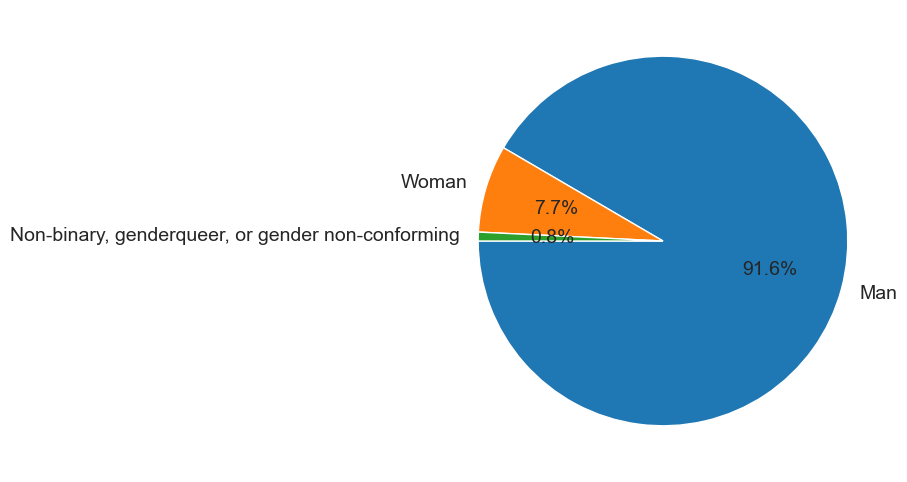

In [88]:
plt.figure(figsize=(12,6))
# plt.title(schema.Gender)
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=180); # autopct for string format, 

Only about 8% of survey respondents who have answered the question identify as women or non-binary. This number is lower than the overall percentage of women & non-binary genders in the programming community - which is estimated to be around 12%. 

**Exercise**: It would be interesting to compare the survey responses & preferences across genders. Repeat this analysis with these breakdowns. How do the relative education levels differ across genders? How do the salaries vary? You may find this analysis on the [Gender Divide in Data Science](https://medium.com/datadriveninvestor/exploratory-data-analysis-eda-understanding-the-gender-divide-in-data-science-roles-9faa5da44f5b) useful.

### Education Level

Formal education in computer science is often considered an essential requirement for becoming a programmer. However, there are many free resources & tutorials available online to learn programming. Let's compare the education levels of respondents to gain some insight into this. We'll use a horizontal bar plot here.

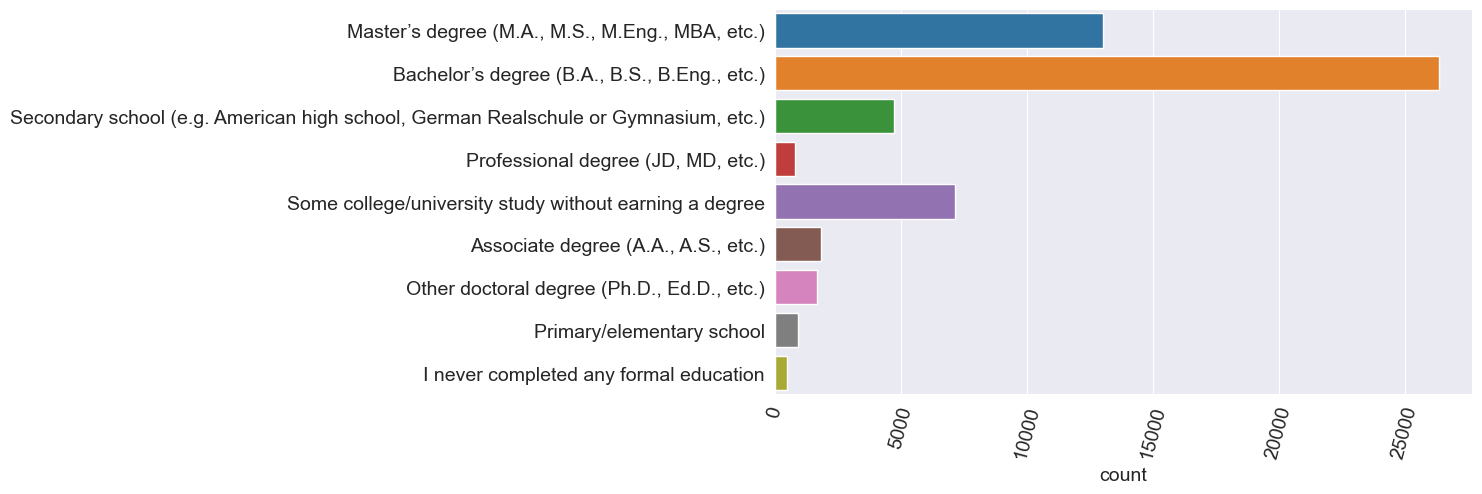

In [90]:
sns.countplot(y=survey_df.EdLevel)
plt.xticks(rotation=75);
# plt.title(schema['EdLevel'])
plt.ylabel(None);

It appears that well over half of the respondents hold a bachelor's or master's degree, so most programmers seem to have some college education. However, it's not clear from this graph alone if they hold a degree in computer science.

<font color= 'blue'>**Exercise**:</font>

The graph currently shows the number of respondents for each option. Can you modify it to show the percentage instead? Further, try comparing the percentages for each degree for men vs. women. 

Let's also plot undergraduate majors, but this time we'll convert the numbers into percentages and sort the values to make it easier to visualize the order.

In [ ]:
schema.UndergradMajor

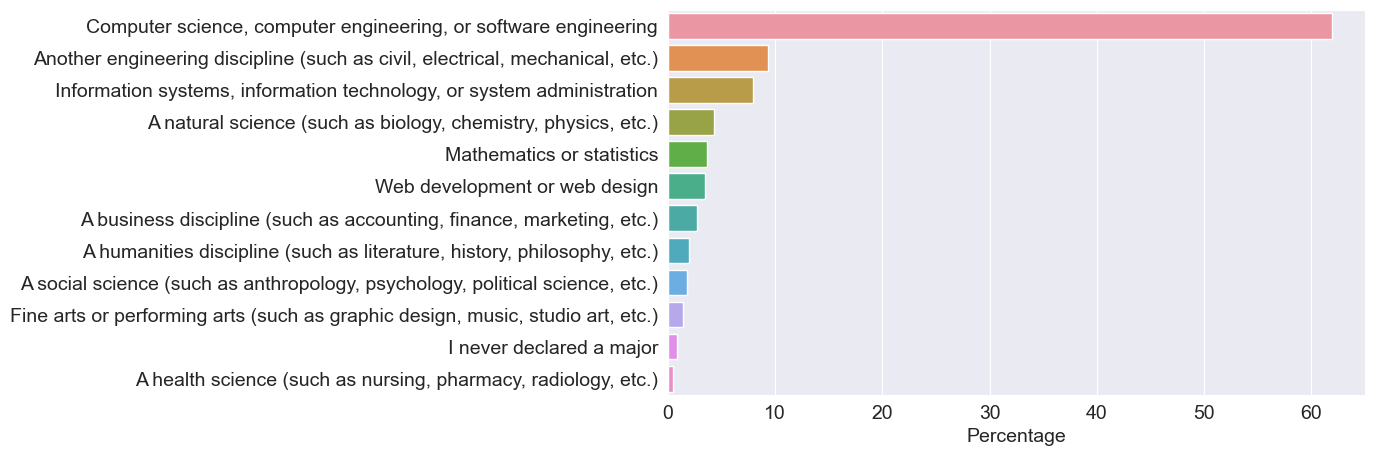

In [92]:
undergrad_pct = survey_df.UndergradMajor.value_counts() * 100 / survey_df.UndergradMajor.count()

sns.barplot(x=undergrad_pct, y=undergrad_pct.index)

# plt.title(schema.UndergradMajor)
plt.ylabel(None);
plt.xlabel('Percentage');

It turns out that 40% of programmers holding a college degree have a field of study other than computer science - which is very encouraging. It seems to suggest that while a college education is helpful in general, you do not need to pursue a major in computer science to become a successful programmer.

**Exercises**: Analyze the `NEWEdImpt` column for respondents who hold some college degree vs. those who don't. Do you notice any difference in opinion?


### Employment

Freelancing or contract work is a common choice among programmers, so it would be interesting to compare the breakdown between full-time, part-time, and freelance work. Let's visualize the data from the `Employment` column.

In [ ]:
schema.Employment

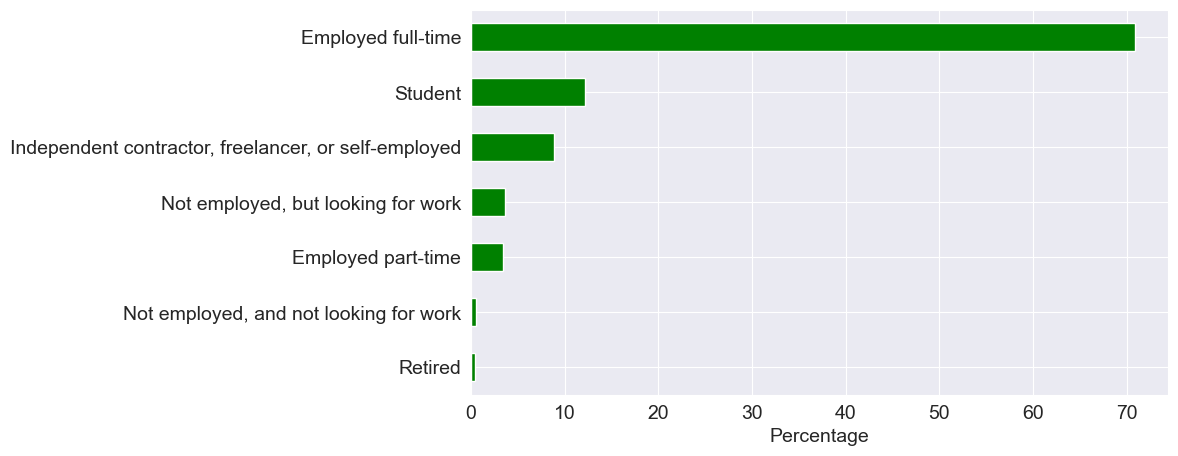

In [94]:
(survey_df.Employment.value_counts(normalize=True, ascending=True)*100).plot(kind='barh', color='g')
# plt.title(schema.Employment)
plt.xlabel('Percentage');

It appears that close to 10% of respondents are employed part time or as freelancers.

<font color= 'blue'>**Exercise**:</font>

Add a new column `EmploymentType` containing the values `Enthusiast` (student or not employed but looking for work), `Professional` (employed full-time, part-time or freelancing), and `Other` (not employed or retired). For each of the graphs that follow, show a comparison between `Enthusiast` and `Professional`.



### Exploring Age1st code: 

<AxesSubplot:xlabel='Age1stCode', ylabel='Count'>

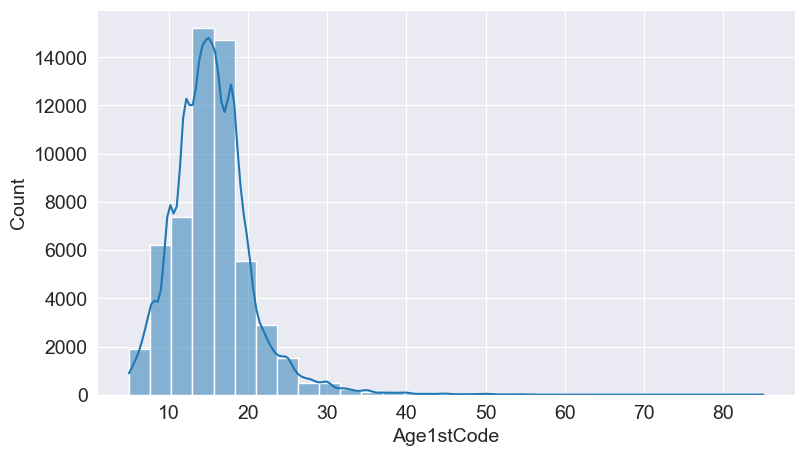

In [96]:
# plt.title(schema.Age1stCode)
sns.histplot(x=survey_df.Age1stCode, bins=30, kde=True)

We've only explored a handful of columns from the 20 columns that we selected. Explore and visualize the remaining columns using the empty cells below.

In [ ]:
schema.YearsCodePro

## Exploring correlation between age and year of code: 

Let's create a scatter plot of `Age` vs. `YearsCodePro` (i.e., years of coding experience) to answer this question.

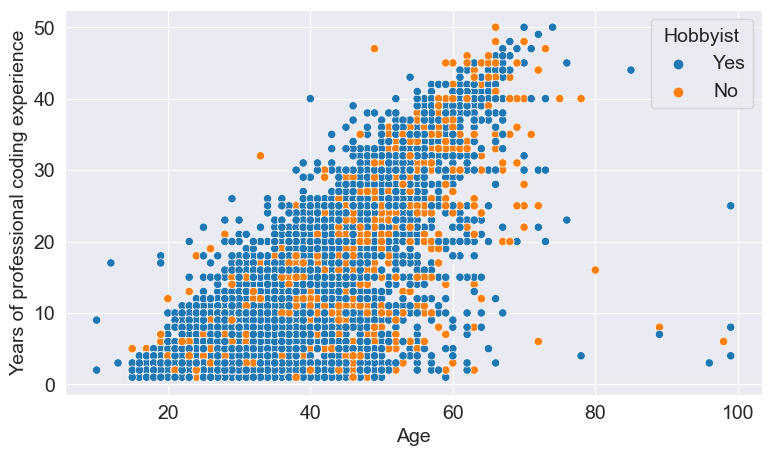

In [98]:
sns.scatterplot(x='Age', y='YearsCodePro', hue='Hobbyist', data=survey_df)
plt.xlabel("Age")
plt.ylabel("Years of professional coding experience");

You can see points all over the graph, which indicates that you can **start programming professionally at any age**. Many people who have been coding for several decades professionally also seem to enjoy it as a hobby.

We can also view the distribution of the `Age1stCode` column to see when the respondents tried programming for the first time.
### Is there any correlation?


In [97]:
from scipy.stats import pearsonr
s_df= survey_df.dropna()
data1 = s_df['Age']
data2 = s_df['YearsCodePro']
# calculate Pearson's correlation
corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.851


There is a strong correlation between Age and years of experience in this grpah

<font color= 'blue'>**Exercise**:</font>

Can you find other correlations in this data?


As you might expect, most people seem to have had some exposure to programming before the age of 40. However, but there are people of all ages and walks of life learning to code.

<font color= 'blue'>**Exercise**:</font>

* How does programming experience change opinions & preferences? Repeat the entire analysis while comparing the responses of people who have more than ten years of professional programming experience vs. those who don't. Do you see any interesting trends?
* Compare the years of professional coding experience across different genders. 


## References and Future Work

Check out the following resources to learn more about the dataset and tools used in this notebook:

- Stack Overflow Developer Survey: https://insights.stackoverflow.com/survey
- Pandas user guide: https://pandas.pydata.org/docs/user_guide/index.html
- Matplotlib user guide: https://matplotlib.org/3.3.1/users/index.html
- Seaborn user guide & tutorial: https://seaborn.pydata.org/tutorial.html